In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print('Current cuda device: ',torch.cuda.get_device_name(0))

In [2]:
!pip install gstools
import gstools as gs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 14.8 MB/s eta 0:00:00


In [3]:
# Codes for the forward tomography problem
class tomography(nn.Module):

    def __init__(self, zs, ze, x, z):
      # rays start at (x[0], zs[i]) and end at (x[-1], ze[j])

        super().__init__()

        self.zs = zs
        self.ze = ze
        self.z  = z
        self.x  = x
        self.A = self.get_tomo_matrix(zs, ze, x, z)


    def get_ray(self, zs, ze, x, z):

        n = x.numel() #64
        X, Z = torch.meshgrid(x, z)


        s = (ze-zs)/(x[-1]-x[0])
        p = s*x + zs

        # Approximate the delta function over the path
        sigma = (x[1]-x[0])*2
        ray = torch.exp(-(X-x.unsqueeze(1))**2/sigma -(Z-p.unsqueeze(1))**2/sigma)
        ray[ray<0.1] = 0
        return ray

    def get_tomo_matrix(self, zs, ze, x, z):

        n = zs.numel() #65*65=4225

        A = torch.zeros(0, x.numel()*z.numel())
        A = A.to_sparse()
        nrays = tqdm.trange(n)

        for i in nrays:
            ray = self.get_ray(zs[i], ze[i], x, z)
            ray = ray.reshape(1, -1)
            ray = ray.to_sparse()
            A = torch.cat((A,ray),dim=0)
            nrays.set_description('Percent computed: {:2f}'.format(100*i/n))

        return A.to(device)

    def forward(self, u):
      return self.A@u.flatten().to(device)

    def adjoint(self, b):
      return self.A.t()@b.flatten().to(device)


In [4]:
x = torch.linspace(0, 63, 64)
z = torch.linspace(0, 127, 128)

t = torch.linspace(0, 127, 65)
zs, ze = torch.meshgrid(t, t)
zs = zs.flatten()
ze = ze.flatten()

tomo = tomography(zs, ze, x, z).to(device)

/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Percent computed: 99.976331: 100%|██████████| 4225/4225 [00:42<00:00, 100.02it/s]


In [5]:
x = np.arange(64)
z = np.arange(128)

model = gs.Gaussian(dim=2, var=0.9, len_scale=[9, 5], anis=0.9, angles=np.pi/8)
srf = gs.SRF(model, mean=0, seed = 100)

srf.structured([x,z])

u_noise = srf.field



Text(0.5, 1.0, 'true')

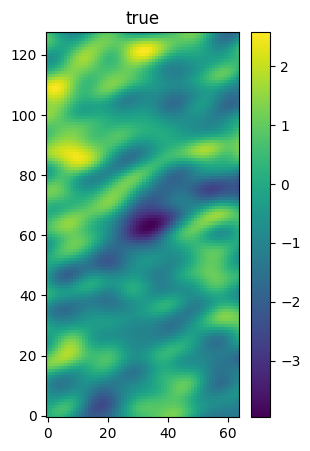

In [6]:
plt.figure(figsize=(15, 5))
plt.subplot(1,4,1)
plt.imshow(u_noise.reshape(64, 128).transpose(), origin = 'lower')
plt.axis('image')
plt.colorbar()
plt.title('true')

In [7]:
utrue = np.ones([64, 128])
a = 20
center_l_i = 25
center_l_j = 44
center_r_i = 45
center_r_j = 74
for j in range(128):
  for i in range(64):
    r1 = ((i - center_l_i)**2 + (j-center_l_j)**2)**0.5
    r2 = ((i - center_r_i)**2 + (j-center_r_j)**2)**0.5
    if r1+r2<=2*a:
      utrue[i,j] = 8
utrue += u_noise
u = torch.tensor(utrue, dtype=torch.float32).to(device)
u[u < 0.3] = 0.3
utrue = u.clone().to(device)

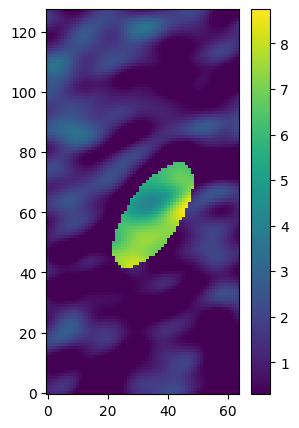

In [8]:

plt.figure(figsize=(15, 5))
plt.subplot(1,4,1)
plt.imshow(utrue.detach().cpu().reshape(64, 128).t(), origin = 'lower')
plt.axis('image')
plt.colorbar()

We can now use the forward model and the simulated model to generate some data we can try to invert

In [9]:
x = torch.linspace(0, 63, 64)
z = torch.linspace(0, 127, 128)

t = torch.linspace(0, 127, 65)
zs, ze = torch.meshgrid(t, t)
zs = zs.flatten()
ze = ze.flatten()

tomo = tomography(zs, ze, x, z).to(device)

Percent computed: 99.976331: 100%|██████████| 4225/4225 [00:17<00:00, 246.06it/s]


In [10]:
d = tomo(u).to(device)
# Add noise to the data
torch.manual_seed(0)
noise = torch.randn_like(d)
sig   = 20
dn = (d + sig*noise).to(device)

SNR = (dn-d).norm()/dn.norm()
print('Noise level = ', (SNR).item())

Noise level =  0.07214528322219849


In [59]:
class TEST(nn.Module):
  def __init__(self):
    super(TEST, self).__init__()
    x = torch.linspace(0, 63, 64)
    z = torch.linspace(0, 127, 128)
    t = torch.linspace(0, 127, 65)
    zs, ze = torch.meshgrid(t, t)
    zs = zs.flatten()
    ze = ze.flatten()
    # tomo = tomography(zs, ze, x, z).to(device)
    #self.u = torch.nn.Parameter(torch.zeros(64, 128))
    self.u = torch.nn.Parameter(torch.ones(64, 128))
    self.u.requires_grad = True
  def forward(self, x):
    v = self.u@x
    return v


In [60]:
def total_loss(output, Jtvec):
      """
          Note beta here differs from the beta in the convential EM inversion where beta typically starts with a value greater than 1 (e.x. 10), and then cooling down with a fixed rate.
          beta: [0,1]
          total_loss = (1-beta)*theta_phi + beta*theta_m
      """

      # return (1/(output.size(dim = 0)))*Jtvec@output.flatten()
      return (1/(output.flatten().size(dim = 0)))*Jtvec@output.flatten()

In [61]:
test_model = TEST().to(device)

In [62]:
import torch.optim as optim
lr_ = 1e-1
optimizer = optim.SGD(test_model.parameters(), lr=lr_)

In [63]:
output = test_model(torch.eye(128).to(device))

Text(0.5, 1.0, 'Steepest decent without regularization')

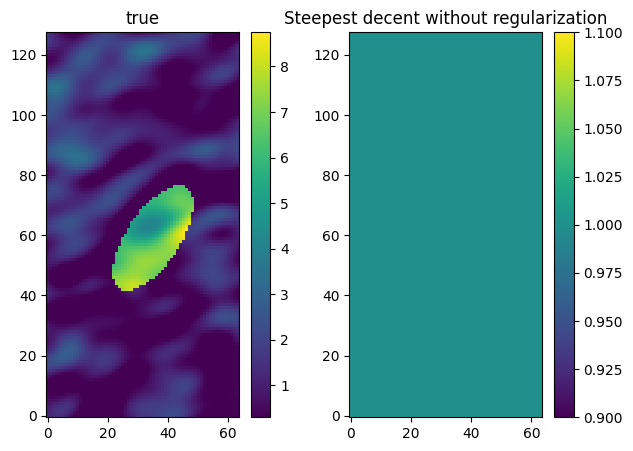

In [64]:
plt.figure(figsize=(15, 5))
plt.subplot(1,4,1)
plt.imshow(utrue.detach().cpu().reshape(64, 128).t(), origin = 'lower')
plt.axis('image')
plt.colorbar()
plt.title('true')
plt.subplot(1,4,2)
plt.imshow(test_model.u.detach().cpu().reshape(64, 128).t(), origin = 'lower')
plt.axis('image')
plt.colorbar()
plt.title('Steepest decent without regularization')

In [65]:
%matplotlib inline
from IPython import display

In [66]:
class smoothness(nn.Module):
    def __init__(self, core_cell_size):
        super(smoothness, self).__init__()
        self.dx = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = (1,2), stride=1, padding=0, bias=False)
        self.dy = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = (2,1), stride=1, padding=0, bias=False)
        self.core_cell_size= core_cell_size
    def forward(self,x):
        x = x[None,None,:,:]
        dx = self.dx(x)
        dy = self.dy(x)
        return (dx/self.core_cell_size,dy/self.core_cell_size)

smooth = smoothness(core_cell_size = 5).to(device)
smooth.dx.weight.data = torch.tensor([[[[-1., 1.]]]]).to(device)
smooth.dx.weight.requires_grad=False
smooth.dy.weight.data = torch.tensor([[[[-1.],[1.]]]]).to(device)
smooth.dy.weight.requires_grad=False

In [67]:
def smooth_loss(output, smooth):
    (dx,dy) = smooth(output)
    dx_sum,dy_sum = torch.matmul(dx.flatten(),dx.flatten()), torch.matmul(dy.flatten(),dy.flatten()) #L2
    return (1/(output.flatten().size(dim = 0)))*(dx_sum+dy_sum)

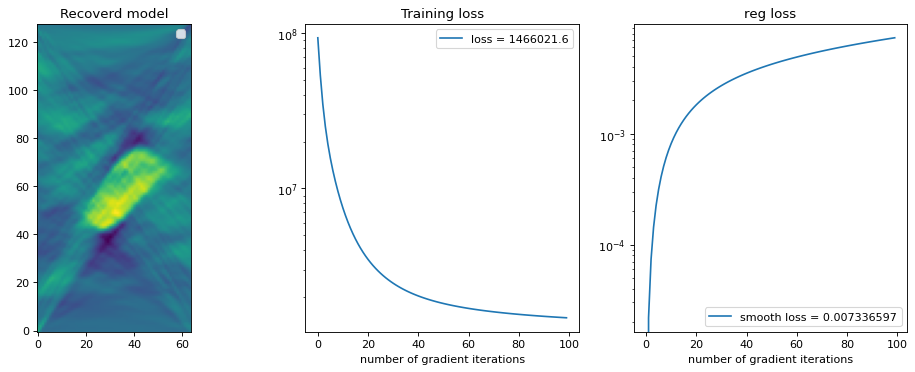

In [68]:
fig = plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)
loss_list = []
l2_smooth_list = []
for epoch in range(100):
    output = test_model(torch.eye(128).to(device))
    Jtvec =2*tomo.A.t()@(tomo.A@output.detach().flatten()-dn)
    L2_smooth = smooth_loss(output, smooth)
    loss = total_loss(output, Jtvec) + 0*L2_smooth
    dif_ = ((tomo.A@(test_model.u.flatten().detach())-dn).norm())**2
    loss_list.append(dif_.detach().cpu().numpy() )
    l2_smooth_list.append(L2_smooth.detach().cpu().numpy())
    if epoch%1 == 0:
      for ax in axes:
        ax.cla()
      axes[0].imshow(test_model.u.detach().cpu().reshape(64, 128).t(), origin = 'lower')
      axes[0].legend()
      axes[0].set_title('Recoverd model')
      axes[1].plot(loss_list, label='loss = ' + str(dif_.detach().cpu().numpy()))
      axes[1].set_yscale('log')
      axes[1].set_title('Training loss')
      axes[1].set_xlabel('number of gradient iterations')
      axes[1].legend()
      axes[2].plot(l2_smooth_list, label='smooth loss = ' + str(L2_smooth.detach().cpu().numpy()))
      axes[2].set_yscale('log')
      axes[2].set_title('reg loss')
      axes[2].set_xlabel('number of gradient iterations')
      axes[2].legend()
      # print("The residual in the ", epoch, "is", ((out_-dn.unsqueeze(-1)).norm())**2)
      display.clear_output(wait=True)
      display.display(plt.gcf())
    # loss_list.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
plt.close('all')

Text(0.5, 1.0, 'Recovered')

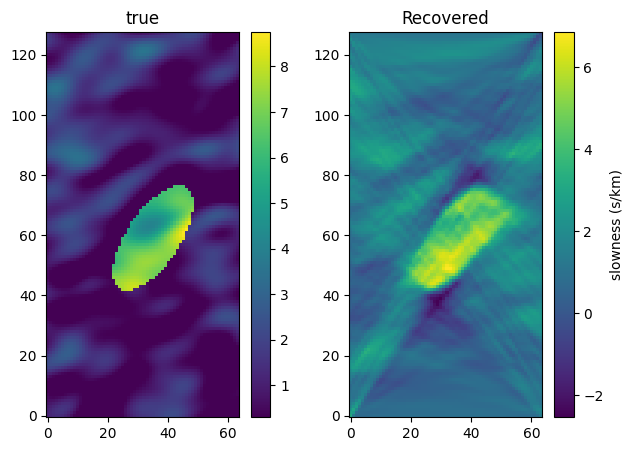

In [69]:
plt.figure(figsize=(15, 5))
plt.subplot(1,4,1)
plt.imshow(utrue.detach().cpu().reshape(64, 128).t(), origin = 'lower')
plt.axis('image')
plt.colorbar()
plt.title('true')
plt.subplot(1,4,2)
plt.imshow(test_model.u.detach().cpu().reshape(64, 128).t(), origin = 'lower')
plt.axis('image')
cbar = plt.colorbar()
cbar.set_label('slowness (s/km)')
plt.title('Recovered')

In [70]:
import pickle
pkl_name = 'no_smooth_Case_2'+'.pkl'
f = open(pkl_name, 'wb')
pickle.dump(test_model.u.detach().cpu(), f)
f.close()

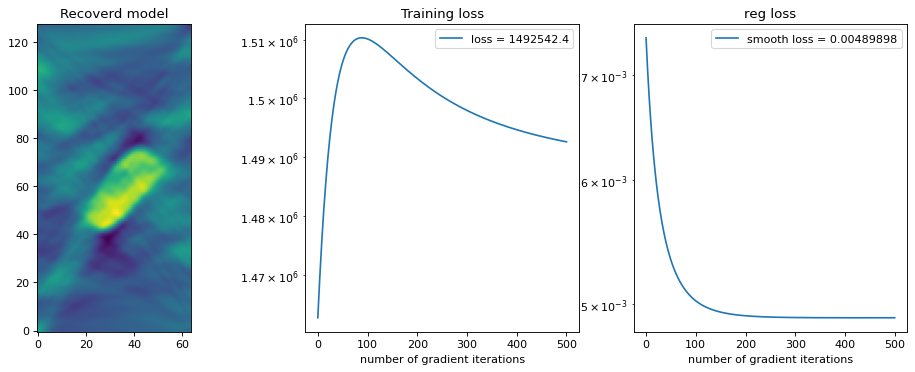

In [71]:
fig = plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)
loss_list = []
l2_smooth_list = []
for epoch in range(1000):
    output = test_model(torch.eye(128).to(device))
    Jtvec =2*tomo.A.t()@(tomo.A@output.detach().flatten()-dn)
    L2_smooth = smooth_loss(output, smooth)
    loss = total_loss(output, Jtvec) + 1e4*L2_smooth
    dif_ = ((tomo.A@(test_model.u.flatten().detach())-dn).norm())**2
    loss_list.append(dif_.detach().cpu().numpy() )
    l2_smooth_list.append(L2_smooth.detach().cpu().numpy())
    if epoch%500 == 0:
      for ax in axes:
        ax.cla()
      axes[0].imshow(test_model.u.detach().cpu().reshape(64, 128).t(), origin = 'lower')
      axes[0].set_title('Recoverd model')
      axes[1].plot(loss_list, label='loss = ' + str(dif_.detach().cpu().numpy()))
      axes[1].set_yscale('log')
      axes[1].set_title('Training loss')
      axes[1].set_xlabel('number of gradient iterations')
      axes[1].legend()
      axes[2].plot(l2_smooth_list, label='smooth loss = ' + str(L2_smooth.detach().cpu().numpy()))
      axes[2].set_yscale('log')
      axes[2].set_title('reg loss')
      axes[2].set_xlabel('number of gradient iterations')
      axes[2].legend()
      # print("The residual in the ", epoch, "is", ((out_-dn.unsqueeze(-1)).norm())**2)
      display.clear_output(wait=True)
      display.display(plt.gcf())
    # loss_list.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
plt.close('all')

In [72]:
import pickle
pkl_name = 'with_smooth_Case_2'+'.pkl'
f = open(pkl_name, 'wb')
pickle.dump(test_model.u.detach().cpu(), f)
f.close()


Text(0.5, 1.0, 'Recovered')

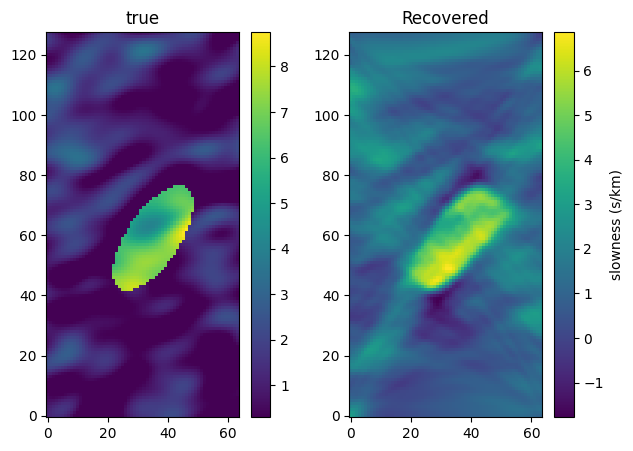

In [73]:
plt.figure(figsize=(15, 5))
plt.subplot(1,4,1)
plt.imshow(utrue.detach().cpu().reshape(64, 128).t(), origin = 'lower')
plt.axis('image')
plt.colorbar()
plt.title('true')
plt.subplot(1,4,2)
plt.imshow(test_model.u.detach().cpu().reshape(64, 128).t(), origin = 'lower')
plt.axis('image')
cbar = plt.colorbar()
cbar.set_label('slowness (s/km)')
plt.title('Recovered')